In [51]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'autism-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F34093%2F3163594%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240330%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240330T122136Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D16a0153c773c5024beaf6819a00ad1f540e4b18704d797012511591d158d2e0750cf2538eeee53732a97dd9fd07843cd95ed312335fedcbb861a80241fa74c4946c27083ceb1c25cd270e3fb198dd89579c5fa5413328efd7bf5e891598c35451fcce37b6d3cdec08f0d008c20b3c7bb9e719e2e3c24b0fb4e9566c8377fb6e4e961ec0ec2f198e39379c4eb04d1aea4c63b9b161cfde35990cb35bda20a870f9a16eab4995a8ccafa1190c0bfd989ab49fa5595ef563c40c852b8ad3784857c9f676800e6f41d513d91c771523d50fb5342cd6228f2143adca884970b591267efe7a29810934b0fc5eeb23789d9450c860fc52f28cd7d79c3373794fd906065'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 26834 bytes downloaded
Downloaded and uncompressed: autism-prediction
Data source import complete.


## Autism spectrum disorder (ASD) Prediction"

One of the community competitions (this one) offered us the opportunity to see autism with data. Let's explore.

**The dataset**: The dataset is composed of survey results of people who filled an app form. There are labels portraying whether the person received a diagnosis of autism.

- **Objective**: Build machine learning models to predict the likelihood of having autism based on the given features.



### Part-1: EDA

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder

from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
pio.templates.default = "none"

import warnings
warnings.filterwarnings('ignore')


PATH = '/kaggle/input/autism-prediction/Autism-prediction/'
train = pd.read_csv(PATH + "/train.csv")
test = pd.read_csv(PATH + "/test.csv")
sample_submission = pd.read_csv(PATH + "/sample_submission.csv")

In [53]:
import numpy as np
from sklearn.utils import resample

# Assuming train and test are your original datasets

# Upsample training data to 8000 samples
train = resample(train, n_samples=10000, random_state=42)

# Upsample testing data to 2000 samples
test = resample(test, n_samples=2000, random_state=42)

# Display the shapes of the upsampled datasets
print("Upsampled Train Shape:", train.shape)
print("Upsampled Test Shape:", test.shape)


Upsampled Train Shape: (10000, 22)
Upsampled Test Shape: (2000, 21)


### Look at the head of the train

Below is the columns description of the datasets

- ID - ID of the patient
- A1_Score to A10_Score - Score based on Autism Spectrum Quotient (AQ) 10 item screening tool
- age - Age of the patient in years
- gender - Gender of the patient
- ethnicity - Ethnicity of the patient
- jaundice - Whether the patient had jaundice at the time of birth
- autism - Whether an immediate family member has been diagnosed with autism
- contry_of_res - Country of residence of the patient
- used_app_before - Whether the patient has undergone a screening test before
- result - Score for AQ1-10 screening test
- age_desc - Age of the patient
- relation - Relation of patient who completed the test
- Class/ASD - Classified result as 0 or 1. Here 0 represents No and 1 represents Yes. This is the target column, and during submission submit the values as 0 or 1 only.

In [54]:
train.head(4)

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
102,103,0,0,0,0,0,0,0,0,0,...,m,Black,no,no,India,no,7.566586,18 and more,Self,0
435,436,1,0,1,1,1,1,1,1,1,...,m,South Asian,yes,no,United States,no,13.231017,18 and more,Self,1
270,271,1,0,0,0,1,0,0,1,1,...,f,Hispanic,yes,no,United Kingdom,no,9.620736,18 and more,Self,0
106,107,0,0,0,0,0,0,0,1,0,...,m,?,yes,no,United Arab Emirates,no,5.095274,18 and more,Self,0


Look at the head of the test¶
Below is the columns description of the datasets

ID - ID of the patient
A1_Score to A10_Score - Score based on Autism Spectrum Quotient (AQ) 10 item screening tool
age - Age of the patient in years
gender - Gender of the patient
ethnicity - Ethnicity of the patient
jaundice - Whether the patient had jaundice at the time of birth
autism - Whether an immediate family member has been diagnosed with autism
contry_of_res - Country of residence of the patient
used_app_before - Whether the patient has undergone a screening test before
result - Score for AQ1-10 screening test
age_desc - Age of the patient
relation - Relation of patient who completed the test

In [55]:
test.head(5)

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation
102,103,1,0,1,1,1,1,1,1,1,...,36.579843,f,Pasifika,no,yes,Canada,no,13.300173,18 and more,Self
179,180,0,1,0,0,0,0,0,1,1,...,23.424870,m,Hispanic,no,no,Ethiopia,no,5.148542,18 and more,Self
92,93,1,0,0,0,1,0,1,1,0,...,26.125983,f,Turkish,no,no,Philippines,no,11.159310,18 and more,Self
14,15,1,1,1,1,1,1,1,1,1,...,64.525612,f,Hispanic,yes,no,Belgium,no,13.150653,18 and more,Self
106,107,1,0,0,0,0,0,0,0,0,...,23.585814,f,South Asian,no,no,United Arab Emirates,no,3.824907,18 and more,?


In [56]:
train['age']= [int(age) for age in train['age']]
test['age']= [int(age) for age in test['age']]

In [57]:
traini = train

In [58]:
train = train.drop('used_app_before', axis=1)
test = test.drop('used_app_before', axis=1)
train = train.drop('result', axis=1)
test = test.drop('result' ,axis=1)
train = train.drop('relation', axis=1)
test = test.drop('relation', axis=1)

### Null Values
- No null values in both train and test datasets

In [59]:
display(train.isna().sum().sum())
display(test.isna().sum().sum())

0

0

### Some data cleaning

In [60]:
# fix the spelling issue
train = train.rename(columns = {'austim': 'autism', 'contry_of_res':'country_of_res'}, errors="raise")
test = test.rename(columns = {'austim': 'autism', 'contry_of_res':'country_of_res'}, errors="raise")

# fix the other/Other capitalization
train['country_of_res'][train['country_of_res'] == 'others'] = 'Others'
test['country_of_res'][test['country_of_res'] == 'others'] = 'Others'

train['ethnicity'][train['ethnicity'] == 'others'] = 'Others'
test['ethnicity'][test['ethnicity'] == 'others'] = 'Others'

In [61]:
# drop un-important cols
train.drop(['ID', 'age_desc'], axis=1, inplace=True)
test.drop(['ID', 'age_desc'], axis=1, inplace=True)

cat_cols = [col for col in train.columns if train[col].dtype == 'object']
num_cols = [col for col in train.columns if train[col].dtype == 'int'][0:-1]



### Check for categorical features uniqueness

In [62]:
for col in cat_cols:
  # Count unique values
  x = train[col].nunique()
  y = test[col].nunique()

  # Get unique values
  unique_train_values = train[col].unique()
  unique_test_values = test[col].unique()

  # Print results
  print("{}: train {} unique, test {} unique".format(col, x, y))
  print("Train unique values:", unique_train_values)
  print("Test unique values:", unique_test_values)
  print()  # Add an empty line for better readability between columns


gender: train 2 unique, test 2 unique
Train unique values: ['m' 'f']
Test unique values: ['f' 'm']

ethnicity: train 11 unique, test 11 unique
Train unique values: ['Black' 'South Asian' 'Hispanic' '?' 'Latino' 'White-European'
 'Middle Eastern ' 'Asian' 'Others' 'Pasifika' 'Turkish']
Test unique values: ['Pasifika' 'Hispanic' 'Turkish' 'South Asian' 'Black' 'White-European'
 'Asian' '?' 'Others' 'Middle Eastern ' 'Latino']

jaundice: train 2 unique, test 2 unique
Train unique values: ['no' 'yes']
Test unique values: ['no' 'yes']

autism: train 2 unique, test 2 unique
Train unique values: ['no' 'yes']
Test unique values: ['yes' 'no']

country_of_res: train 61 unique, test 44 unique
Train unique values: ['India' 'United States' 'United Kingdom' 'United Arab Emirates'
 'New Zealand' 'Mexico' 'South Africa' 'Romania' 'Malaysia' 'Afghanistan'
 'Sri Lanka' 'Australia' 'Aruba' 'Russia' 'Saudi Arabia' 'Bahamas'
 'Netherlands' 'Belgium' 'Canada' 'Jordan' 'France' 'China' 'Austria'
 'Iran' 'Spa

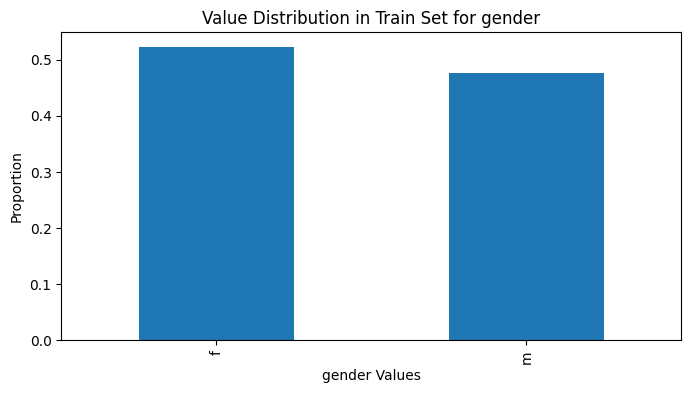

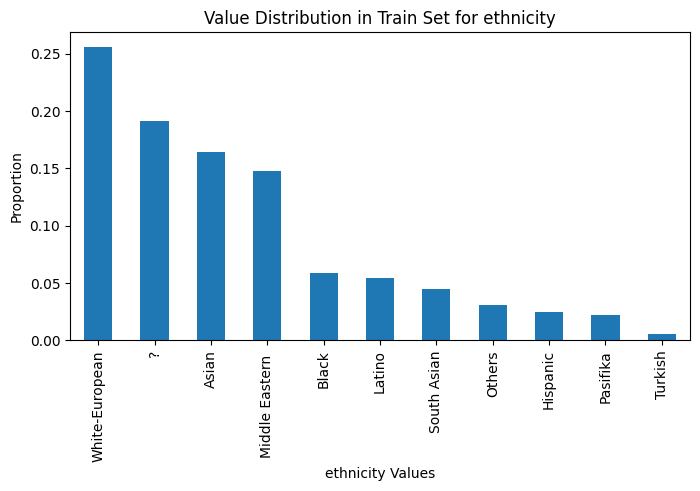

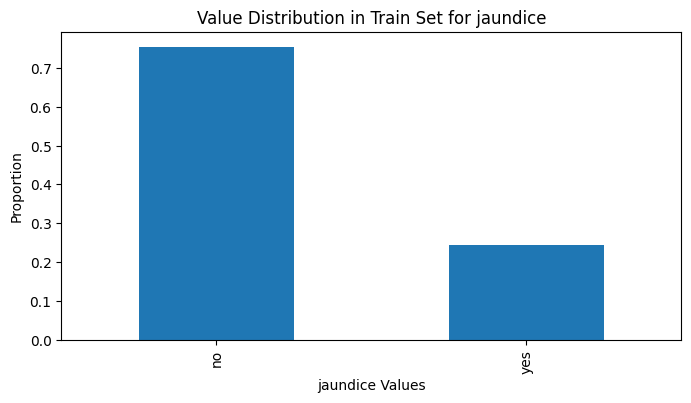

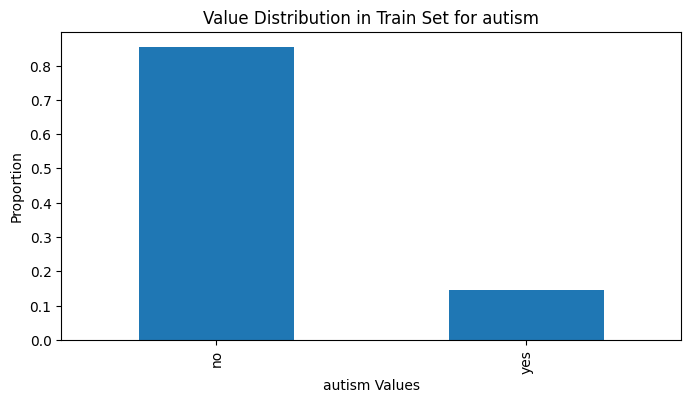

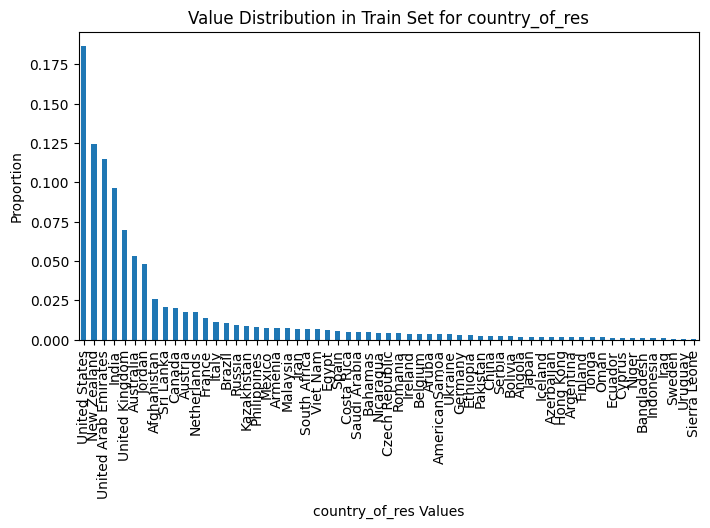

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your data in DataFrames named 'train' and 'test'
cat_cols = ['gender', 'ethnicity', 'jaundice', 'autism', 'country_of_res']


# Create bar graphs for each categorical feature
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    train[col].value_counts(normalize=True).plot(kind='bar')
    plt.title(f"Value Distribution in Train Set for {col}")
    plt.xlabel(col + " Values")
    plt.ylabel("Proportion")
    plt.show()

    # Optionally, create bar graphs for test set as well:
    # test[col].value_counts(normalize=True).plot(kind='bar')
    # plt.title(f"Value Distribution in Test Set for {col}")
    # plt.xlabel(col)
    # plt.ylabel("Proportion")
    # plt.show()


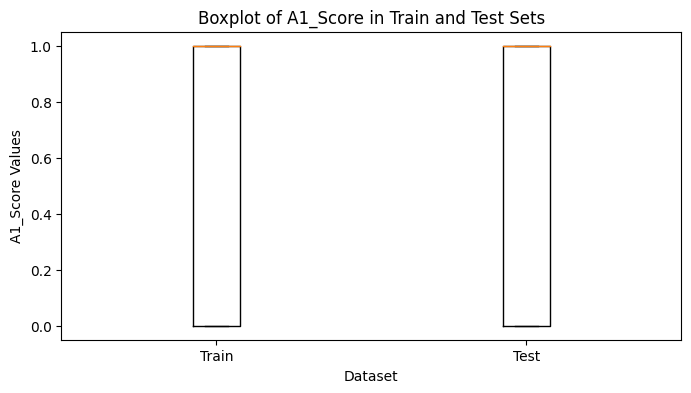

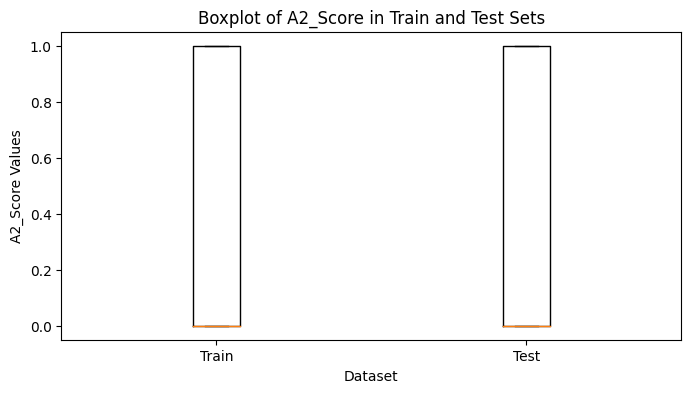

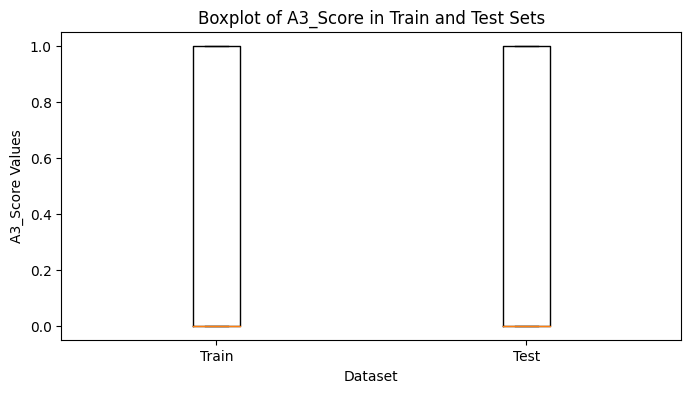

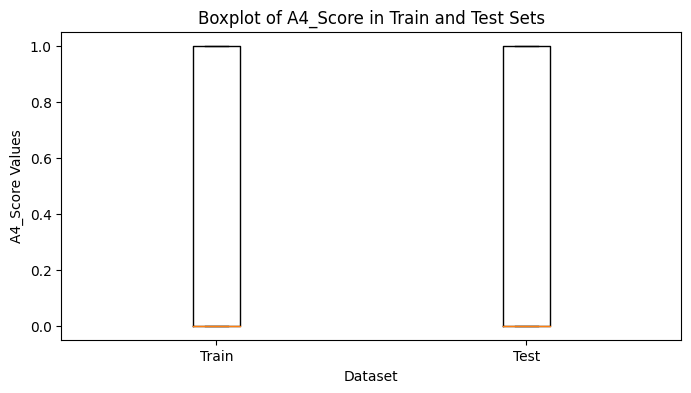

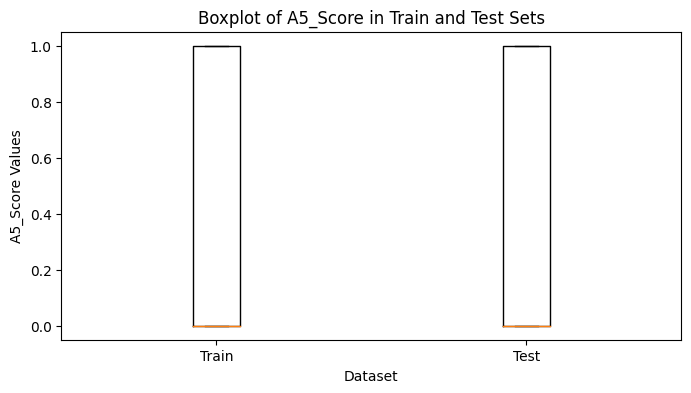

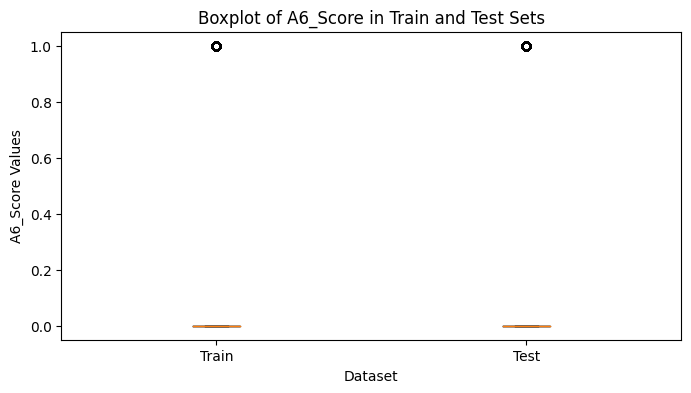

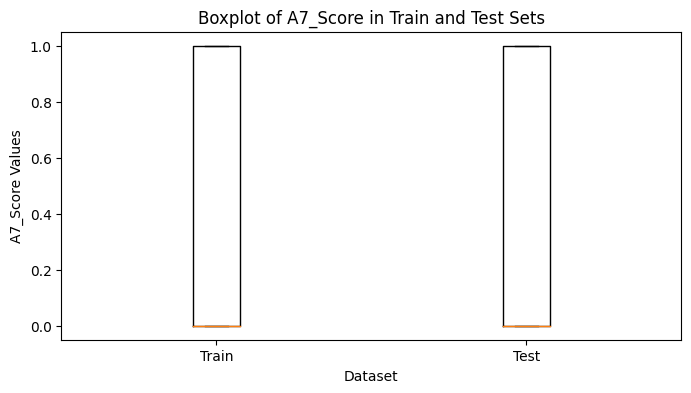

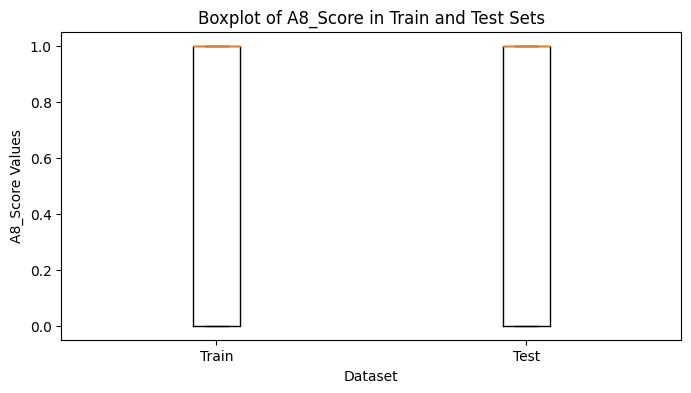

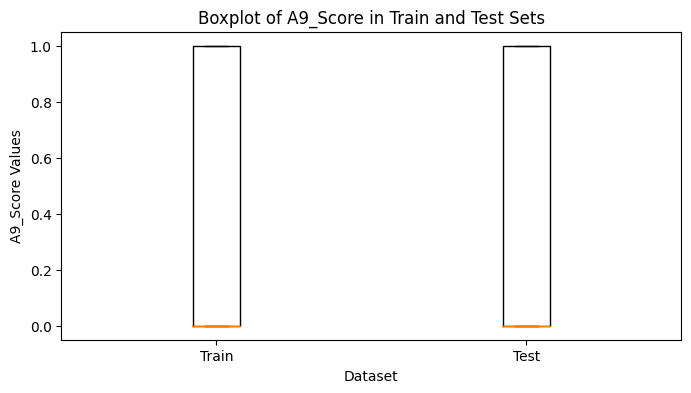

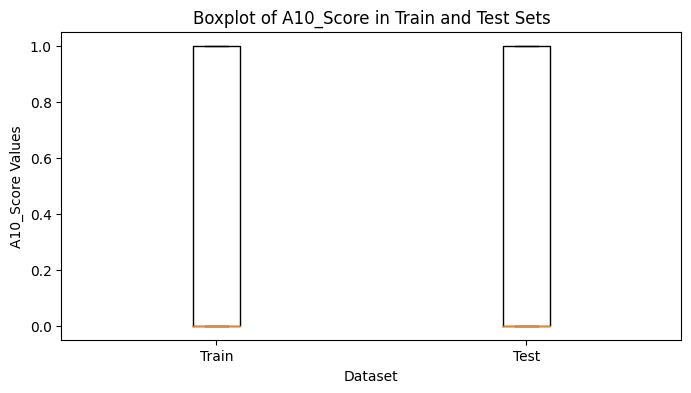

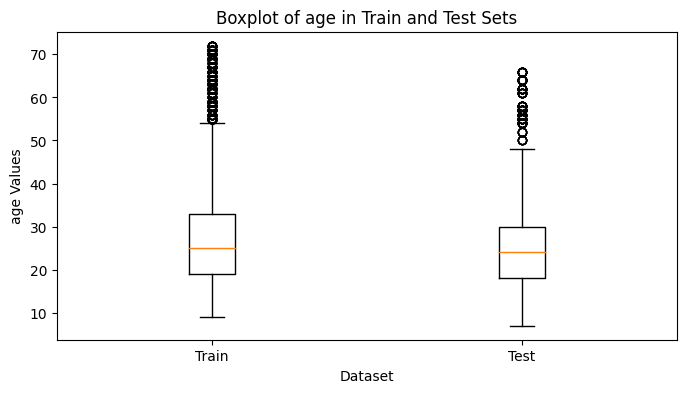

In [65]:

# Create boxplots for each categorical feature
for col in num_cols:
    plt.figure(figsize=(8, 4))  # Set figure size for better readability
    plt.boxplot([train[col], test[col]], labels=['Train', 'Test'])
    plt.title(f"Boxplot of {col} in Train and Test Sets")
    plt.xlabel("Dataset")
    plt.ylabel(col + " Values")
    plt.show()

In [66]:
label_encoder = LabelEncoder()
train_le = train.copy()
test_le = test.copy()

for col in cat_cols:
        train_le[col] = label_encoder.fit_transform(train[col])
        test_le[col] = label_encoder.fit_transform(test[col])

train = train_le
test = test_le

In [67]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming 'Class/ASD' is the target variable in your dataset train
# Separate the features (X) and target variable (y)
X_train = train.drop(columns=['Class/ASD'])
y_train = train['Class/ASD']

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)  # Set sampling_strategy to 'auto' for 50:50 ratio
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Convert the balanced data back to DataFrame
X_train_balanced_df = pd.DataFrame(X_train_balanced, columns=X_train.columns)
y_train_balanced_series = pd.Series(y_train_balanced, name='Class/ASD')

# Concatenate X_train_balanced_df and y_train_balanced_series
train_balanced = pd.concat([X_train_balanced_df, y_train_balanced_series], axis=1)

# Check the class distribution after balancing
print(train_balanced['Class/ASD'].value_counts())


0    7708
1    7708
Name: Class/ASD, dtype: int64


0    7708
1    7708
Name: Class/ASD, dtype: int64


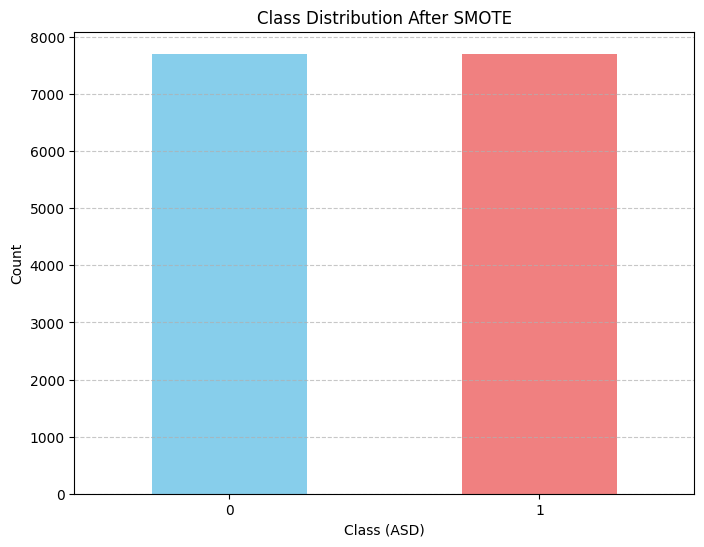

In [68]:
class_counts = train_balanced['Class/ASD'].value_counts()
print(class_counts)

# Create the bar chart
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
class_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])  # Colors for each class
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class (ASD)")
plt.ylabel("Count")
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines
plt.show()

<!-- AQ_score = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']

for item in AQ_score:
    fig = px.histogram(train,
                 x=item,  
                 color='Class/ASD',
                 barmode='group',
                 histnorm='percent',
                 template='simple_white',
                 width=400, height=330,
                 color_discrete_sequence=['purple', 'salmon'],                                   
                )
    fig.update_layout(title="Distribusion of : " + item,
                      font_family="San Serif",
                      titlefont={'size': 20},
                      template='simple_white',
                      showlegend=False,
                      bargap=0.1,
                      bargroupgap=0.1
                     )
    fig.show() -->

### Modeling
- Build simple models such Logistic regression, SVM and Naive Bayes

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


# Training SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_balanced_df, y_train_balanced_series)

# Testing SVM model
svm_predictions = svm_model.predict(X_train_balanced_df)
svm_accuracy = accuracy_score(y_train_balanced_series, svm_predictions)


# Training Logistic Regression model
lr_model = LogisticRegression(solver='saga',
                              tol=1e-5,
                              max_iter=10000,
                              random_state=0,
                              C=0.22685190926977272,
                              penalty='l2'
                             )
lr_model.fit(X_train_balanced_df, y_train_balanced_series)

lr_predictions = lr_model.predict(X_train_balanced_df)
lr_accuracy = accuracy_score(y_train_balanced_series, lr_predictions)
print("Logistic Regression Accuracy:", svm_accuracy)
print("SVM Accuracy:", lr_accuracy)
nb_model = GaussianNB()
nb_model.fit(X_train_balanced_df, y_train_balanced_series)
nb_predictions = nb_model.predict(X_train_balanced_df)
nb_accuracy = accuracy_score(y_train_balanced_series, nb_predictions)
print("Naive Bayes Accuracy:", lr_accuracy)

Logistic Regression Accuracy: 0.8600155682407888
SVM Accuracy: 0.8555396990140114
Naive Bayes Accuracy: 0.8555396990140114


In [70]:
X_train_balanced_df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,autism,country_of_res
0,0,0,0,0,0,0,0,0,0,0,47,1,2,0,0,27
1,1,0,1,1,1,1,1,1,1,1,23,1,8,1,0,58
2,1,0,0,0,1,0,0,1,1,0,19,0,3,1,0,57
3,0,0,0,0,0,0,0,1,0,0,27,1,0,1,0,56
4,0,1,0,0,0,0,0,0,0,0,17,0,4,1,0,39


In [78]:
X_train_balanced_df['country_of_res'].unique()

array([27, 58, 57, 56, 39, 37, 50, 45, 36,  0, 52,  6,  5, 46, 47,  9, 38,
       11, 14, 34, 23, 15,  7, 29, 51, 13, 48, 43, 31,  4, 44, 32, 60,  3,
        1, 25, 24, 59,  8, 16, 26, 35, 21, 20, 18, 54, 55, 40, 12, 33, 49,
        2, 42, 28, 22, 17, 30, 41, 10, 53, 19])

In [79]:
X_train_balanced_df['ethnicity'].unique()

array([ 2,  8,  3,  0,  4, 10,  5,  1,  6,  7,  9])

In [71]:
y_train_balanced_series.head()

0    0
1    1
2    0
3    0
4    0
Name: Class/ASD, dtype: int64

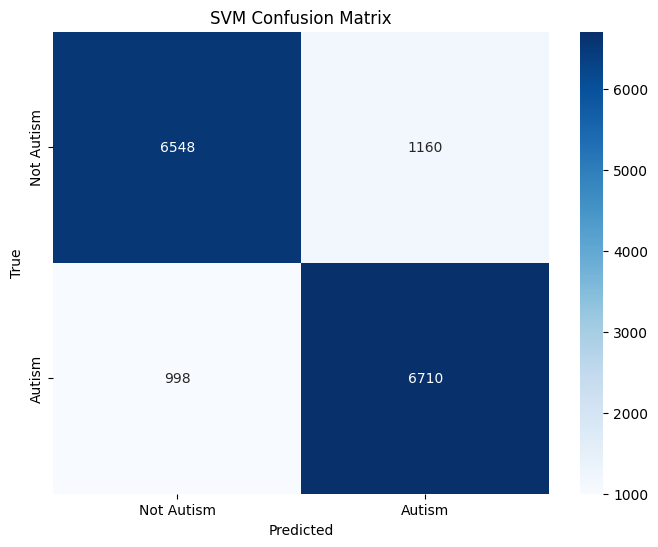

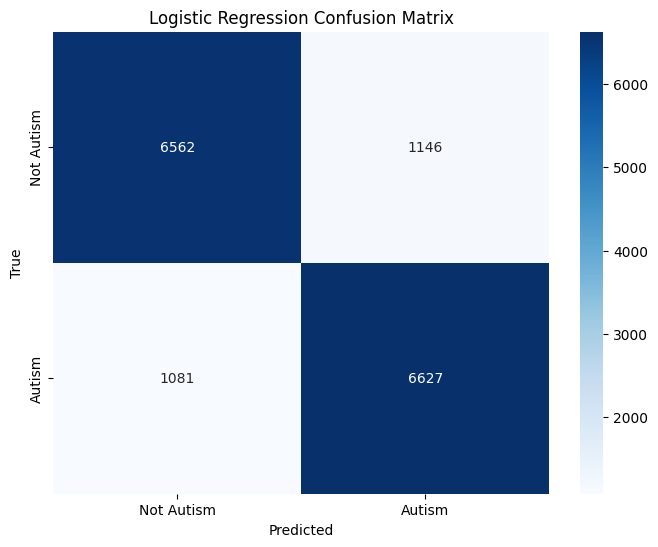

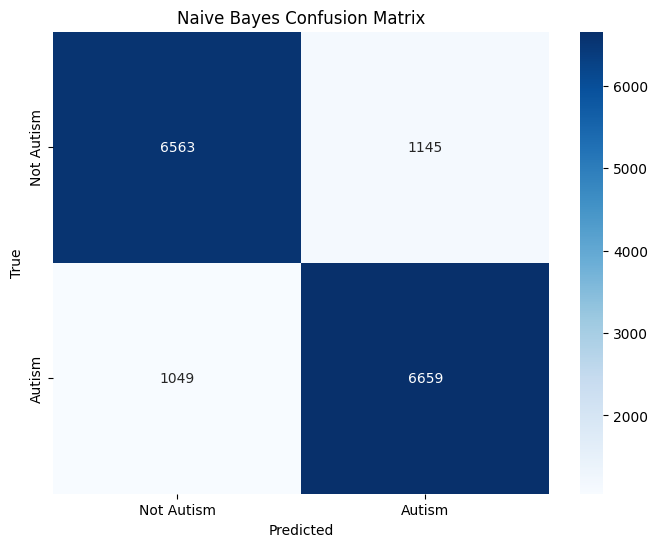

In [72]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Confusion matrix for SVM
svm_conf_matrix = confusion_matrix(y_train_balanced_series, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Not Autism', 'Autism'],
            yticklabels=['Not Autism', 'Autism'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Confusion matrix for Logistic Regression
lr_conf_matrix = confusion_matrix(y_train_balanced_series, lr_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(lr_conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Not Autism', 'Autism'],
            yticklabels=['Not Autism', 'Autism'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_train_balanced_series, nb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Not Autism', 'Autism'],
            yticklabels=['Not Autism', 'Autism'])
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [73]:
import pickle
# Save models as pickle files

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

with open('nb_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

print("Models saved successfully!")

Models saved successfully!


In [74]:
import numpy as np

def sigmoid(x):
    return 1/(1+np.exp(-x))

class LogisticRegression():

    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = sigmoid(linear_pred)

            dw = (1/n_samples) * np.dot(X.T, (predictions - y))
            db = (1/n_samples) * np.sum(predictions-y)

            self.weights = self.weights - self.lr*dw
            self.bias = self.bias - self.lr*db


    def predict(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        y_pred = sigmoid(linear_pred)
        class_pred = [0 if y<=0.5 else 1 for y in y_pred]
        return class_pred

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


clf = LogisticRegression(lr=0.01)
clf.fit(X_train_balanced_df,y_train_balanced_series)
y_pred = clf.predict(X_train_balanced_df)

def accuracy(y_pred, y_test):
    return np.sum(y_pred==y_train_balanced_series)/len(y_train_balanced_series)

acc = accuracy(y_pred, y_train_balanced_series)
print(acc)

0.5967176959003633


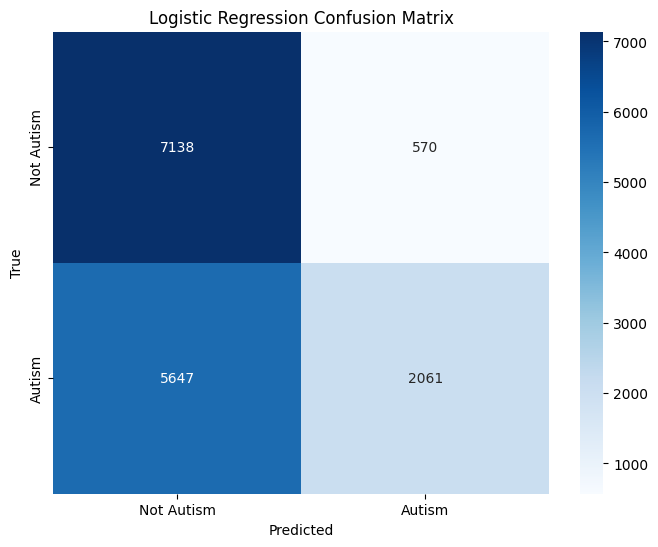

In [75]:
# Confusion matrix for Logistic Regression
lr_conf_matrix = confusion_matrix(y_train_balanced_series, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(lr_conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Not Autism', 'Autism'],
            yticklabels=['Not Autism', 'Autism'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()